# Diabetes Regression Model 

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
import copy, math 

In [44]:
data = pd.read_csv('diabetes.csv')

In [45]:
data.shape[0]

442

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   age                                              442 non-null    float64
 1   sex                                              442 non-null    float64
 2   bmi                                              442 non-null    float64
 3   Average blood pressure                           442 non-null    float64
 4   Total serum cholesterol (tc)                     442 non-null    float64
 5   Low-density lipoproteins (ldl)                   442 non-null    float64
 6   High-density lipoproteins (hdl)                  442 non-null    float64
 7   Total cholesterol / HDL (tch)                    442 non-null    float64
 8   Possibly log of serum triglycerides level (ltg)  442 non-null    float64
 9   Blood sugar level (glu)         

**Data used from sklearn is already standarized so there no need for going throuth the cleaning process,except gender**

In [47]:
gender_data = data['sex']
not_equal_values = gender_data[(gender_data != 0.050680) | (gender_data != -0.044642)] 

print(not_equal_values) 


0      0.050680
1     -0.044642
2      0.050680
3     -0.044642
4     -0.044642
         ...   
437    0.050680
438    0.050680
439    0.050680
440   -0.044642
441   -0.044642
Name: sex, Length: 442, dtype: float64


**Turns out there is inly two values**

**The target variable represents a quantitative measure of disease progression one year after baseline for each patient.**

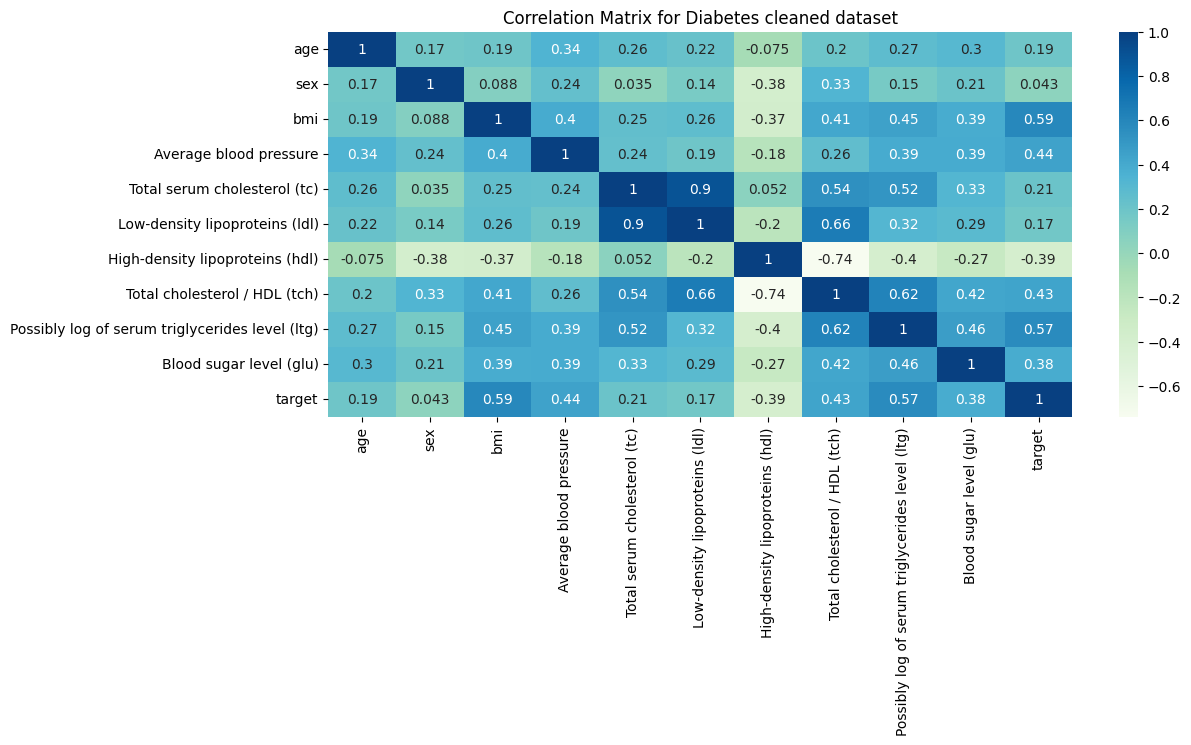

In [48]:
# correlation matrix 

corr_mat = data.corr() 
plt.figure(figsize=(12,5)) 
sns.heatmap(data=corr_mat, annot=True, cmap='GnBu') 
plt.title("Correlation Matrix for Diabetes cleaned dataset")
plt.show()

**Note that:**

A. Correlations between target and other variables are ranked from strong to weak as follows:
   1. BMI with 0.59
   2. LTG with 0.57
   3. ABP with 0.44
   4. TCH with 0.43
   5. HDI with 0.39
   6. GLU with 0.38
   7. TC with 0.21
   8. AGE with 0.19
   9. LDL with 0.17
   10. Gender with 0.043

B. The correlation between TC and LDL is 0.9, which is high enough to consider removing one of them. The variable to be removed will be LDL since it has a lower correlation with the target variable.

C. The correlation between the target variable and gender is nearly zero, so it will be removed as well.

In [49]:
data.drop(columns=['Low-density lipoproteins (ldl)'], inplace=True)
data.drop(columns=['sex'], inplace=True)
data.head()


,age,bmi,Average blood pressure,Total serum cholesterol (tc),High-density lipoproteins (hdl),Total cholesterol / HDL (tch),Possibly log of serum triglycerides level (ltg),Blood sugar level (glu),target
0,0.038076,0.061696,0.021872,-0.044223,-0.043401,-0.002592,0.019907,-0.017646,151
1,-0.001882,-0.051474,-0.026328,-0.008449,0.074412,-0.039493,-0.068332,-0.092204,75
2,0.085299,0.044451,-0.005670,-0.045599,-0.032356,-0.002592,0.002861,-0.025930,141
3,-0.089063,-0.011595,-0.036656,0.012191,-0.036038,0.034309,0.022688,-0.009362,206
4,0.005383,-0.036385,0.021872,0.003935,0.008142,-0.002592,-0.031988,-0.046641,135


In [50]:
X_train = data[["age","bmi","Average blood pressure","Total serum cholesterol (tc)","High-density lipoproteins (hdl)","Total cholesterol / HDL (tch)","Possibly log of serum triglycerides level (ltg)"	,"Blood sugar level (glu)"]].values

Y_train = data[["target"]].values

In [51]:
b_init = np.random.uniform(low=-0.1, high=0.1) 

w_init = np.random.uniform(low=-0.1, high=0.1, size=(8,))  # 8 weights

print(f"Initial bias (b_init): {b_init:.6f}")
print(f"Initial weights (w_init): {w_init}")

Initial bias (b_init): 0.093097
Initial weights (w_init): [-0.06082916 -0.01140096  0.01377586  0.01280849  0.09565785 -0.08497098
  0.03707903  0.05086988]


<a name="toc_15456_3"></a>
# Model Prediction With Multiple Variables
The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

To demonstrate the dot product, we will implement prediction using (1) and (2).

<a name="toc_15456_4"></a>
# Compute Cost With Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


In contrast to previous labs, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

In [52]:
# j(w,b) = 1/(2m) * sum (f_wb - y)^2 
def compute_cost(X, y, w, b): 
    m = X.shape[0] 
    cost = 0.0 
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost 

In [53]:
# Compute and display cost using our pre-chosen optimal parameters. 
cost = compute_cost(X_train, Y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}') 

Cost at optimal w : [14523.2404184]


<a name="toc_15456_5"></a>
# Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


In [54]:
def compute_gradient(X, y, w, b):

    
    m = X.shape[0]  # Number of training examples
    n = X.shape[1]  # Number of features
    dj_dw = np.zeros_like(w)  # Gradient of weights
    dj_db = 0.0  # Gradient of bias

    for i in range(m):
        # Compute error for each example
        err = (np.dot(X[i], w) + b) - y[i]

        # Update gradients
        dj_dw += err * X[i]
        dj_db += err

    # Average gradients over all examples 
    dj_dw /= m
    dj_db /= m

    return dj_db, dj_dw


In [55]:
tmp_dj_dw, tmp_dj_db = compute_gradient(X_train, Y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}') 

dj_db at initial w,b: [-0.68831942 -2.14815205 -1.61708331 -0.77661183  1.44633923 -1.57692564
 -2.07279823 -1.40097192]
dj_dw at initial w,b: 
 [-152.040387]


In [56]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):    
    m = len(x)  # Number of training examples
    n = x.shape[1]  # Number of features
    
    # Lists to store cost and parameter history
    J_history = []
    w_history = []
    
    # Initialize parameters
    w = np.copy(w_in) 
    b = b_in
    
    for i in range(num_iters):
        # Compute gradients
        dj_db, dj_dw = gradient_function(x, y, w, b)
        
        # Update parameters
        w -= alpha * dj_dw
        b -= alpha * dj_db
        
        # Compute cost
        cost = cost_function(x, y, w, b) 
        J_history.append(cost) 
        
        # Print cost every 10 iterations 
        if i % max(1, num_iters // 10) == 0:
            print(f"Iteration {i:4}: Cost {cost}")
            w_history.append(np.copy(w))
        
    return w, b, J_history, w_history


In [57]:
# some gradient descent settings
iterations = 5000
alpha = .1 
# run gradient descent 
w_final, b_final, J_hist,w_hist = gradient_descent(X_train, Y_train, w_init, b_init,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(w_final, b_final)
print(w_hist[-1], J_hist[-1]) 

Iteration    0: Cost [12325.28018591]
Iteration  500: Cost [2289.78024707]
Iteration 1000: Cost [1964.79052397]
Iteration 1500: Cost [1801.04533884]
Iteration 2000: Cost [1713.05453052]
Iteration 2500: Cost [1661.57748659]
Iteration 3000: Cost [1628.4445094]
Iteration 3500: Cost [1605.11376065]
Iteration 4000: Cost [1587.4654751]
Iteration 4500: Cost [1573.429489]
[  23.54001592  400.21349653  252.23513578  -13.49596012 -179.77442202
  124.5812198   332.69434922  133.70851865] [152.13348421]
[  28.57758139  384.54743745  245.75121413   -3.81552646 -178.9423444
  130.079291    321.37222104  136.53543183] [1561.92164706]


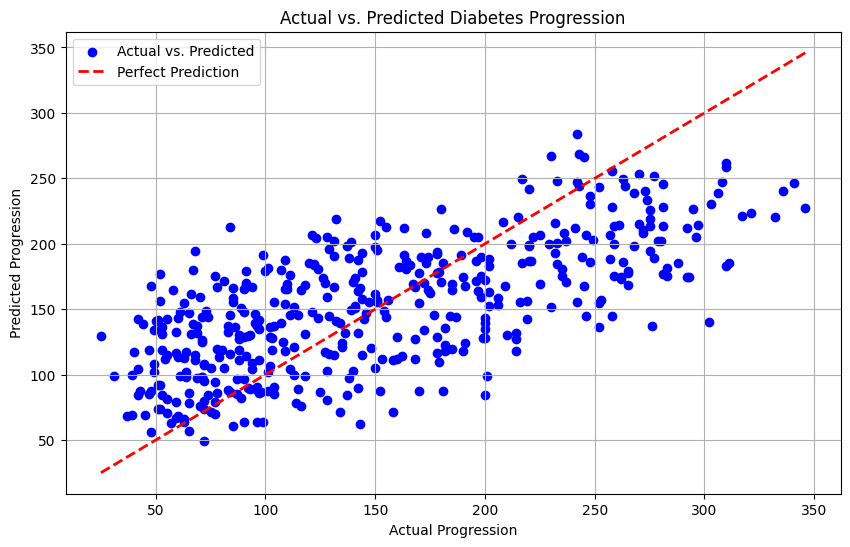

In [58]:
# Predictions using final parameters
predictions = np.dot(X_train, w_final) + b_final

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, predictions, color='blue', label='Actual vs. Predicted')
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted Diabetes Progression')
plt.xlabel('Actual Progression')
plt.ylabel('Predicted Progression')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
SXX = np.sum((X_train - np.mean(X_train))**2)
SYY = np.sum((Y_train - np.mean(Y_train))**2)
SXY = np.sum((X_train - np.mean(X_train)) * (Y_train - np.mean(Y_train)))

In [60]:
SST = np.sum((Y_train - Y_train.shape[0] * np.mean(Y_train))**2)
SSE = np.sum((Y_train - predictions)**2)
SSR = SST - SSE
R2 = 1 - SSE / SST
print(R2)

0.999181342851914
